# HLCA Figure 2

Here we will generate the figures from the HLCA pre-print, figure 2. Figure 2d was generated separately in R, using code from integration benchmarking framework 'scIB'.

### import modules, set paths and parameters:

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import sys
import os
from collections import Counter

sys.path.append("../../scripts/")
import reference_based_harmonizing
import celltype_composition_plotting
import plotting
import sankey

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import ast

In [2]:
sc.set_figure_params(
    dpi=140,
    fontsize=12,
    frameon=False,
    transparent=True,
)

In [3]:
sns.set_style(style="white")
sns.set_context(context="paper")

for pretty code formatting (not needed to run notebook):

In [4]:
%load_ext lab_black

paths:

In [5]:
path_HLCA = "../../data/HLCA_core_h5ads/HLCA_v2.h5ad"
path_celltype_reference = "../../supporting_files/metadata_harmonization/HLCA_cell_type_reference_mapping_20220712.csv"
dir_figures = "../../results/figures"

## Generate figures:

initiate empty dictionary in which to store paper figures.

In [6]:
FIGURES = dict()

for automatic script updating and pretty coding (not necessary for code to run!)

In [7]:
adata = sc.read(path_HLCA)

#### Overview of stats (number of studies, cells, annotations etc.):

Number of studies, datasets, subjects, samples, cells:

In [8]:
print("Number of studies:", len(set(adata.obs.study)))
print("Number of datasets:", len(set(adata.obs.dataset)))
print("Number of subjects:", len(set(adata.obs.subject_ID)))
print("Number of samples:", len(set(adata.obs["sample"])))
print("Number of cells:", adata.obs.shape[0])

Number of studies: 11
Number of datasets: 14
Number of subjects: 107
Number of samples: 166
Number of cells: 584944


Proportions of cell compartments in the HLCA:

In [9]:
original_ann_lev_1_percs = np.round(
    adata.obs.original_ann_level_1.value_counts() / adata.n_obs * 100, 1
)
print("Original annotation proportions (level 1):")
print(original_ann_lev_1_percs)

Original annotation proportions (level 1):
Epithelial             48.1
Immune                 38.7
Endothelial             8.5
Stroma                  4.3
Proliferating cells     0.3
Name: original_ann_level_1, dtype: float64


Perc. of cells annotated per level:

In [10]:
for level in range(1, 6):
    n_unannotated = np.sum(
        [
            isnone or isnull
            for isnone, isnull in zip(
                adata.obs[f"original_ann_level_{level}_clean"].values == "None",
                pd.isnull(adata.obs[f"original_ann_level_{level}_clean"].values),
            )
        ]
    )
    n_annotated = adata.n_obs - n_unannotated
    print(
        f"Perc. originally annotated at level {level}: {round(n_annotated/adata.n_obs*100,1)}"
    )

Perc. originally annotated at level 1: 100.0
Perc. originally annotated at level 2: 98.8
Perc. originally annotated at level 3: 93.6
Perc. originally annotated at level 4: 65.7
Perc. originally annotated at level 5: 6.8


Distribution of demographics:

In [11]:
print(f"Min. and max. age: {adata.obs.age.min()}, {adata.obs.age.max()}")

Min. and max. age: 10.0, 76.0


In [12]:
adata.obs.sex.value_counts() / adata.n_obs * 100

male      60.476558
female    39.523442
Name: sex, dtype: float64

In [13]:
adata.obs.ethnicity.value_counts() / adata.n_obs * 100

white               65.219064
black               14.429928
nan                 13.598396
latino               2.415787
mixed                2.344840
asian                1.610411
pacific islander     0.381575
Name: ethnicity, dtype: float64

In [14]:
print(f"Min. and max. BMI: {adata.obs.BMI.min()}, {adata.obs.BMI.max()}")

Min. and max. BMI: 19.9, 48.9


In [15]:
adata.obs.smoking_status.value_counts() / adata.n_obs * 100

never     51.593144
nan       17.297724
former    15.784246
active    15.324886
Name: smoking_status, dtype: float64

## figures:

Overview of subjects, samples, and cells per study (not in the paper):

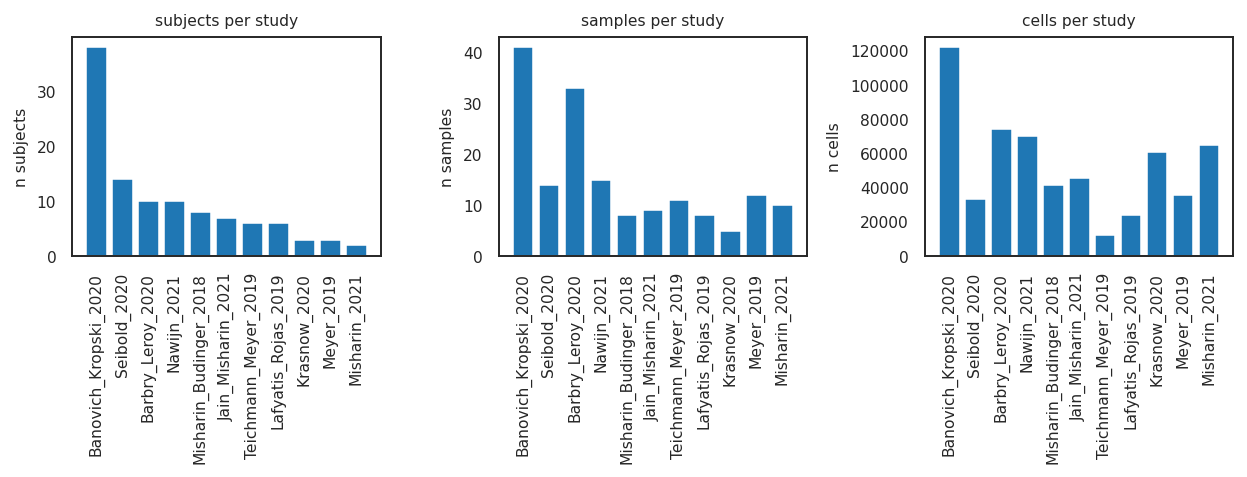

In [16]:
plotting.plot_dataset_statistics(adata, fontsize=8, figheightscale=3.5)

### 2a Subject/sample distributions

Re-map ethnicities to more common ancestry terms (not perfect but best we can do?):

In [17]:
ethnicity_remapper = {
    "asian": "asian",
    "black": "african",
    "latino": "american",
    "mixed": "mixed",
    "nan": "nan",
    "pacific islander": "pacific islander",
    "white": "european",
}

In [18]:
adata.obs.ethnicity = adata.obs.ethnicity.map(ethnicity_remapper)

Plot subject demographic and sample anatomical location distributions:

age: 99% annotated
BMI: 70% annotated
sex: 100% annotated)
ethnicity 93% annotated
smoking_status: 92% annotated


/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


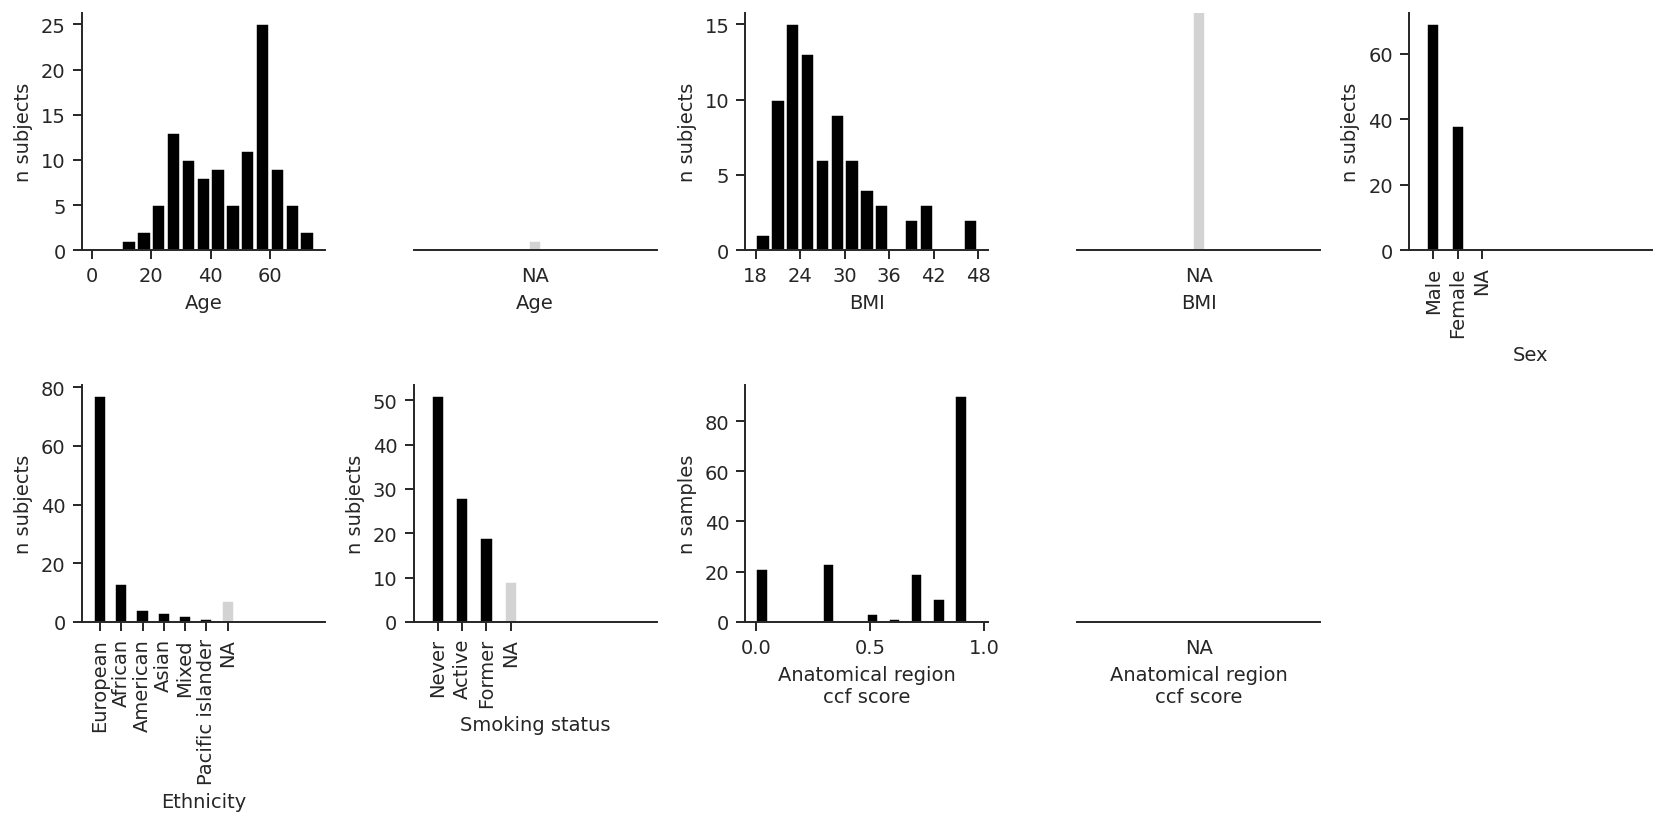

In [19]:
FIGURES["2a_subject_and_sample_stats"] = plotting.plot_subject_and_sample_stats_incl_na(
    adata, return_fig=True
)

## 2b Cell type composition sankey plot, level 1-3:

First, generate a color mapping. We want to map cell types from the same compartment in the same shade (e.g. epithilial orange/red, endothelial purple), at all levels. We'll need to incorporate our hierarchical cell type reference for that, and then calculate the colors per level. That is done with the code below:

In [22]:
harmonizing_df = reference_based_harmonizing.load_harmonizing_table(
    path_celltype_reference
)
consensus_df = reference_based_harmonizing.create_consensus_table(harmonizing_df)
max_level = 5
color_prop_df = celltype_composition_plotting.calculate_hierarchical_coloring_df(
    adata,
    consensus_df,
    max_level,
    lev1_colormap_dict={
        "Epithelial": "Oranges",
        "Immune": "Greens",
        "Endothelial": "Purples",
        "Stroma": "Blues",
        "Proliferating cells": "Reds",
    },
    ann_level_name_prefix="original_ann_level_",
)

/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Set minimum percentage among plotted cells for a cell type to be included. This prevents the plot from becoming overcrowded with labels and including lines that are too thin to even see:

In [23]:
min_ct_perc = 0.02

Now generate the two sankey plots. 

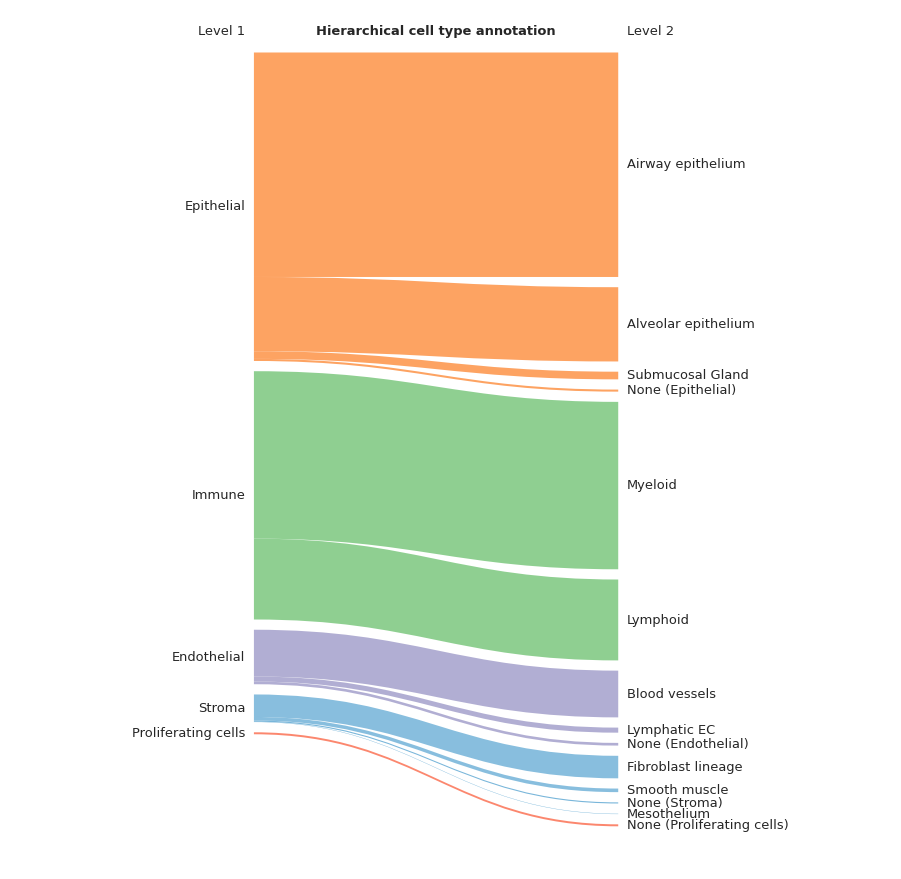

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))
cts_ordered_left_lev1 = [
    ct
    for ct in color_prop_df.l1_label
    if ct in adata.obs.original_ann_level_1_clean.values
]
ct_to_color_lev1 = {
    ct: col for ct, col in zip(color_prop_df.l1_label, color_prop_df.l1_rgba)
}
# get level 1 anns:
y_lev1 = adata.obs.original_ann_level_1_clean
lev1_percs = {ct: n / len(y_lev1) * 100 for ct, n in Counter(y_lev1).items()}
lev1_ct_to_keep = [ct for ct, perc in lev1_percs.items() if perc > min_ct_perc]


# get level 1 anns, set "None" in level 2 compartment specific,
# remove cell types that make up less than min_ct_perc of cells plotted
y_lev2 = adata.obs.original_ann_level_2_clean.cat.remove_unused_categories()
y_lev2 = [
    f"{ct} ({lev1ann})" if ct == "None" else ct
    for ct, lev1ann in zip(y_lev2, adata.obs.original_ann_level_1_clean)
]
lev2_percs = {ct: n / len(y_lev2) * 100 for ct, n in Counter(y_lev2).items()}
lev2_ct_to_keep = [ct for ct, perc in lev2_percs.items() if perc > min_ct_perc]
# plot sankeyy
sankey.sankey(
    x=[
        lev1
        for lev1, lev2 in zip(y_lev1, list(y_lev2))
        if lev1 in lev1_ct_to_keep and lev2 in lev2_ct_to_keep
    ],
    y=[
        lev2
        for lev1, lev2 in zip(y_lev1, list(y_lev2))
        if lev1 in lev1_ct_to_keep and lev2 in lev2_ct_to_keep
    ],
    title="Hierarchical cell type annotation",
    title_left="Level 1",
    title_right="Level 2",
    ax=ax,
    fontsize="x-small",
    left_order=cts_ordered_left_lev1,
    colors={
        ct: to_hex(ast.literal_eval(ct_to_color_lev1[ct]))
        for ct in cts_ordered_left_lev1
    },
    alpha=0.8,
)
plt.show()
plt.close()
FIGURES["2b_sankey_1_2"] = fig

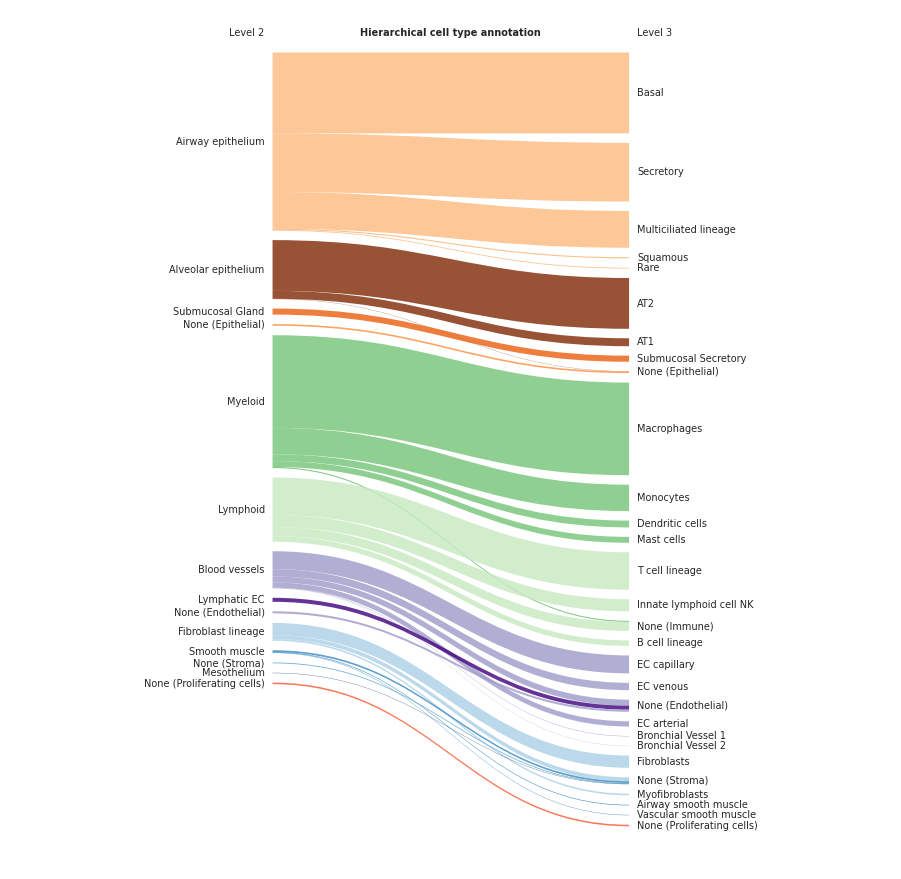

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
# use order from earlier sankey plot
cts_ordered_left_lev2 = [
    ct
    for ct in [
        "Airway epithelium",
        "Alveolar epithelium",
        "Submucosal Gland",
        "None (Epithelial)",
        "Myeloid",
        "Lymphoid",
        "Megakaryocytic and erythroid",
        "Granulocytes",
        "Blood vessels",
        "Lymphatic EC",
        "None (Endothelial)",
        "Fibroblast lineage",
        "Smooth muscle",
        "None (Stroma)",
        "Mesothelium",
        "None (Proliferating cells)",
    ]
    if ct in lev2_ct_to_keep
]
#     ct for ct in color_prop_df.l2_label if ct in adata.obs.ann_level_2_clean.values
# ]
ct_to_color_lev2 = {
    ct: col for ct, col in zip(color_prop_df.l2_label, color_prop_df.l2_rgba)
}
# manually locate colors fo "None" cell type annotations:
for none_ct in "Epithelial", "Endothelial", "Stroma", "Proliferating cells":
    ct_to_color_lev2[f"None ({none_ct})"] = color_prop_df.loc[
        color_prop_df.l1_label == none_ct, "l1_rgba"
    ].values[0]
y_lev3 = adata.obs.original_ann_level_3_clean
y_lev3 = [
    f"{ct} ({lev1ann})" if ct.startswith("None") else ct
    for ct, lev1ann in zip(y_lev3, adata.obs.original_ann_level_1_clean)
]
lev3_percs = {ct: n / len(y_lev3) * 100 for ct, n in Counter(y_lev3).items()}
lev3_ct_to_keep = [ct for ct, perc in lev3_percs.items() if perc > min_ct_perc]
sankey.sankey(
    x=[
        lev2
        for lev2, lev3 in zip(y_lev2, list(y_lev3))
        if lev2 in lev2_ct_to_keep and lev3 in lev3_ct_to_keep
    ],
    y=[
        lev3
        for lev2, lev3 in zip(y_lev2, list(y_lev3))
        if lev2 in lev2_ct_to_keep and lev3 in lev3_ct_to_keep
    ],
    title="Hierarchical cell type annotation",
    title_left="Level 2",
    title_right="Level 3",
    ax=ax,
    fontsize=5,  # "xx-small",
    left_order=cts_ordered_left_lev2,
    colors={
        ct: to_hex(ast.literal_eval(ct_to_color_lev2[ct]))
        for ct in cts_ordered_left_lev2
    },
    alpha=0.8,
)
plt.show()
plt.close()
FIGURES["2b_sankey_2_3"] = fig

### Cell type composition by study and by sample anatomical location:

In [26]:
study_count_per_ct = pd.crosstab(adata.obs.manual_ann, adata.obs.study)
study_perc_per_ct = (
    study_count_per_ct.divide(study_count_per_ct.sum(axis=1), axis=0) * 100
)
anatomical_loc_count_per_ct = pd.crosstab(
    adata.obs.manual_ann, adata.obs.anatomical_region_level_1
)
anatomical_loc_perc_per_ct = (
    anatomical_loc_count_per_ct.divide(anatomical_loc_count_per_ct.sum(axis=1), axis=0)
    * 100
)

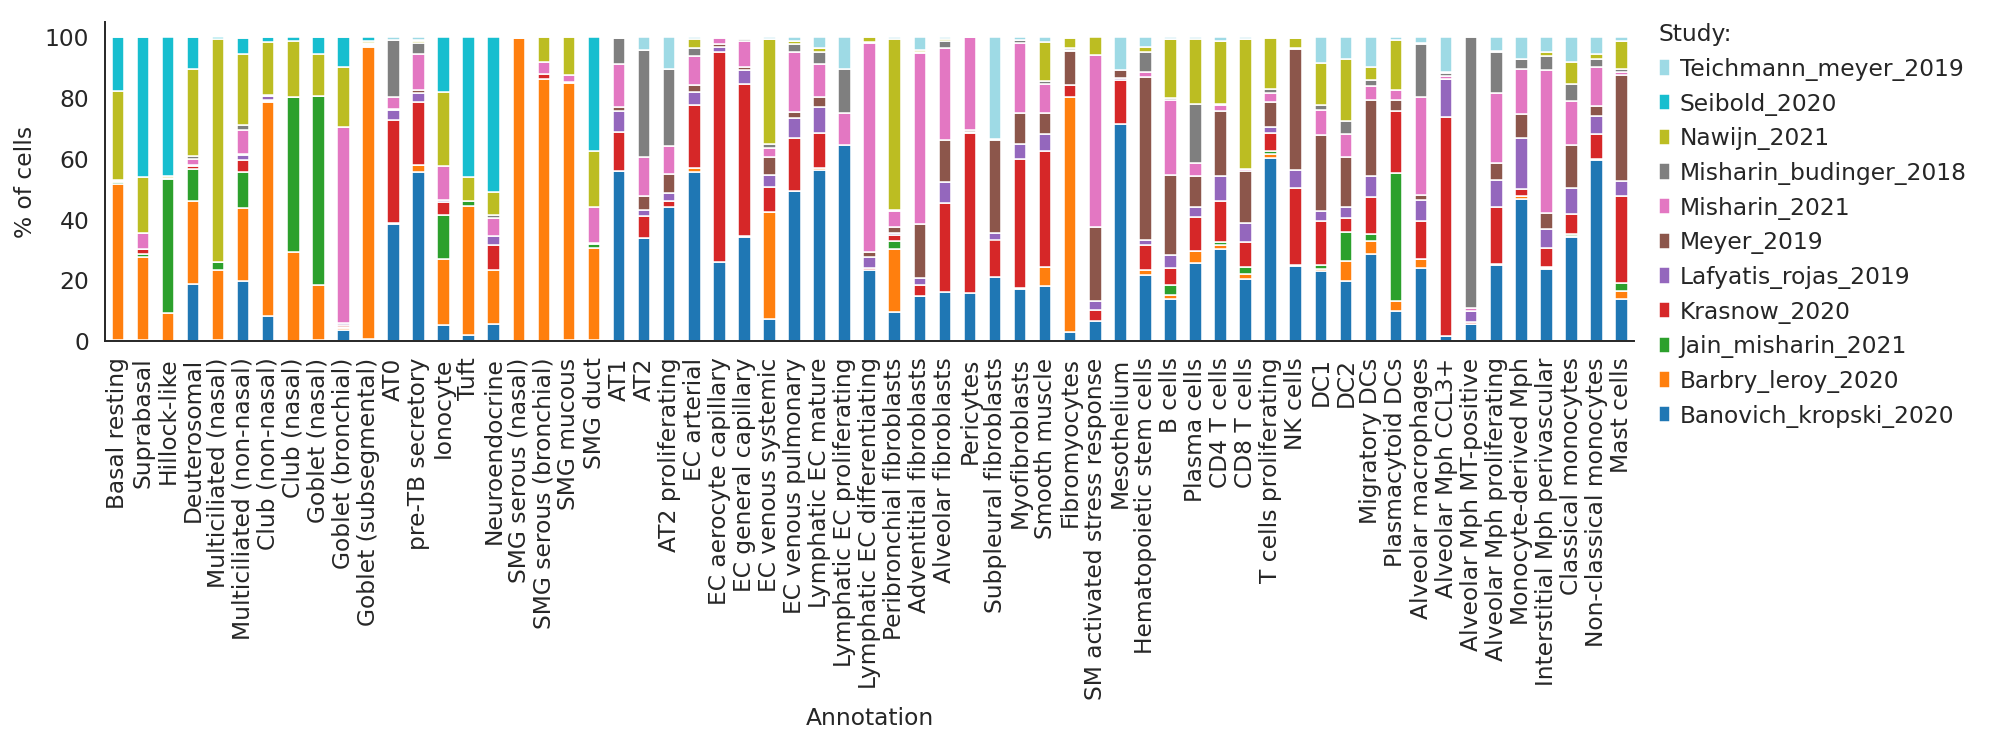

In [32]:
fz = 12
with plt.rc_context(
    {
        "figure.figsize": (14, 3),
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots()
    study_perc_per_ct.plot(kind="bar", stacked=True, ax=ax, cmap="tab20")
    handles, labels = ax.get_legend_handles_labels()
    labels = [lab.capitalize() for lab in labels]
    ax.legend(
        handles[::-1],
        labels[::-1],
        loc=(1.01, -0.3),
        fontsize=fz,
        frameon=False,
        title="Study:",
    )
    leg = ax.get_legend()
    leg._legend_box.align = "left"
    plt.ylabel("% of cells")
    plt.xlabel("Annotation")
    FIGURES["ED_cell_type_study_composition"] = fig

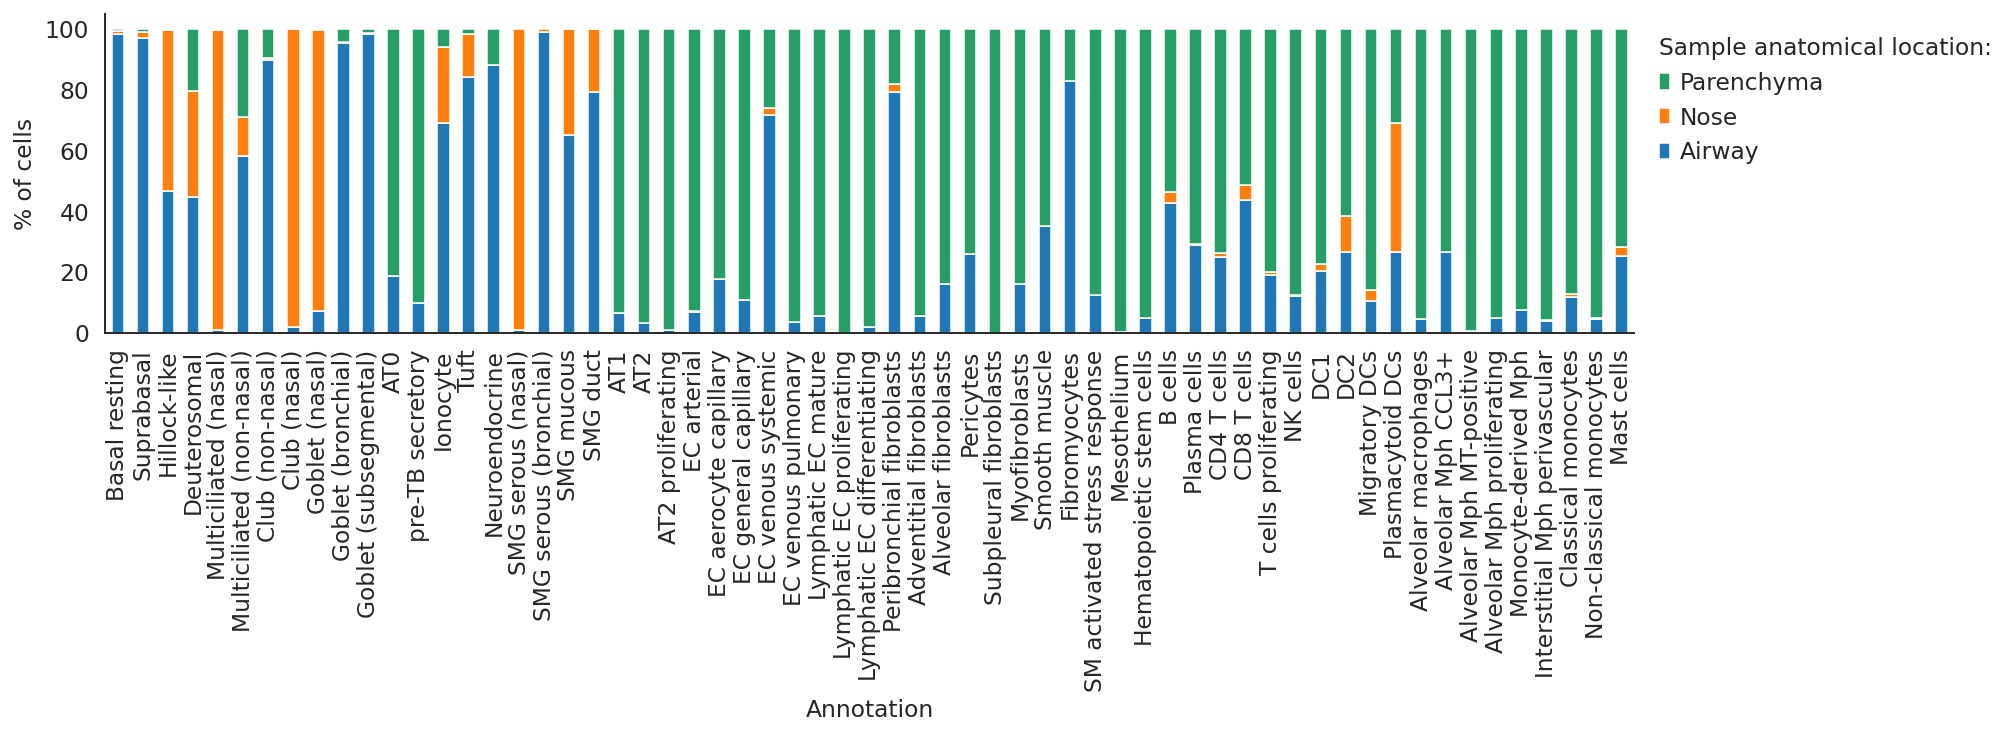

In [33]:
fz = 12
with plt.rc_context(
    {
        "figure.figsize": (14, 3),
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots()
    anatomical_loc_perc_per_ct.plot(kind="bar", stacked=True, ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    labels = [lab.capitalize() for lab in labels]
    ax.legend(
        handles[::-1],
        labels[::-1],
        loc=(1.01, 0.5),
        fontsize=fz,
        frameon=False,
        title="Sample anatomical location:",
    )
    leg = ax.get_legend()
    leg._legend_box.align = "left"
    plt.ylabel("% of cells")
    plt.xlabel("Annotation")
    FIGURES["ED_cell_type_anatomical_region_composition"] = fig

### 2c Sample compositions:

In the paper we use ann level 2 and group by sample:

In [34]:
ann_level_number = "2"
grouping_covariate = "sample"  # choose e.g. "dataset" or "subject_ID" or "sample"

Use the "clean" version, i.e. without forward-propagated labels for cells not annotated at the chosen label, but leaving those cells set to "None":

In [35]:
if ann_level_number == "1":
    ann_level = "original_ann_level_" + ann_level_number
else:
    ann_level = "original_ann_level_" + ann_level_number + "_clean"

Now plot:

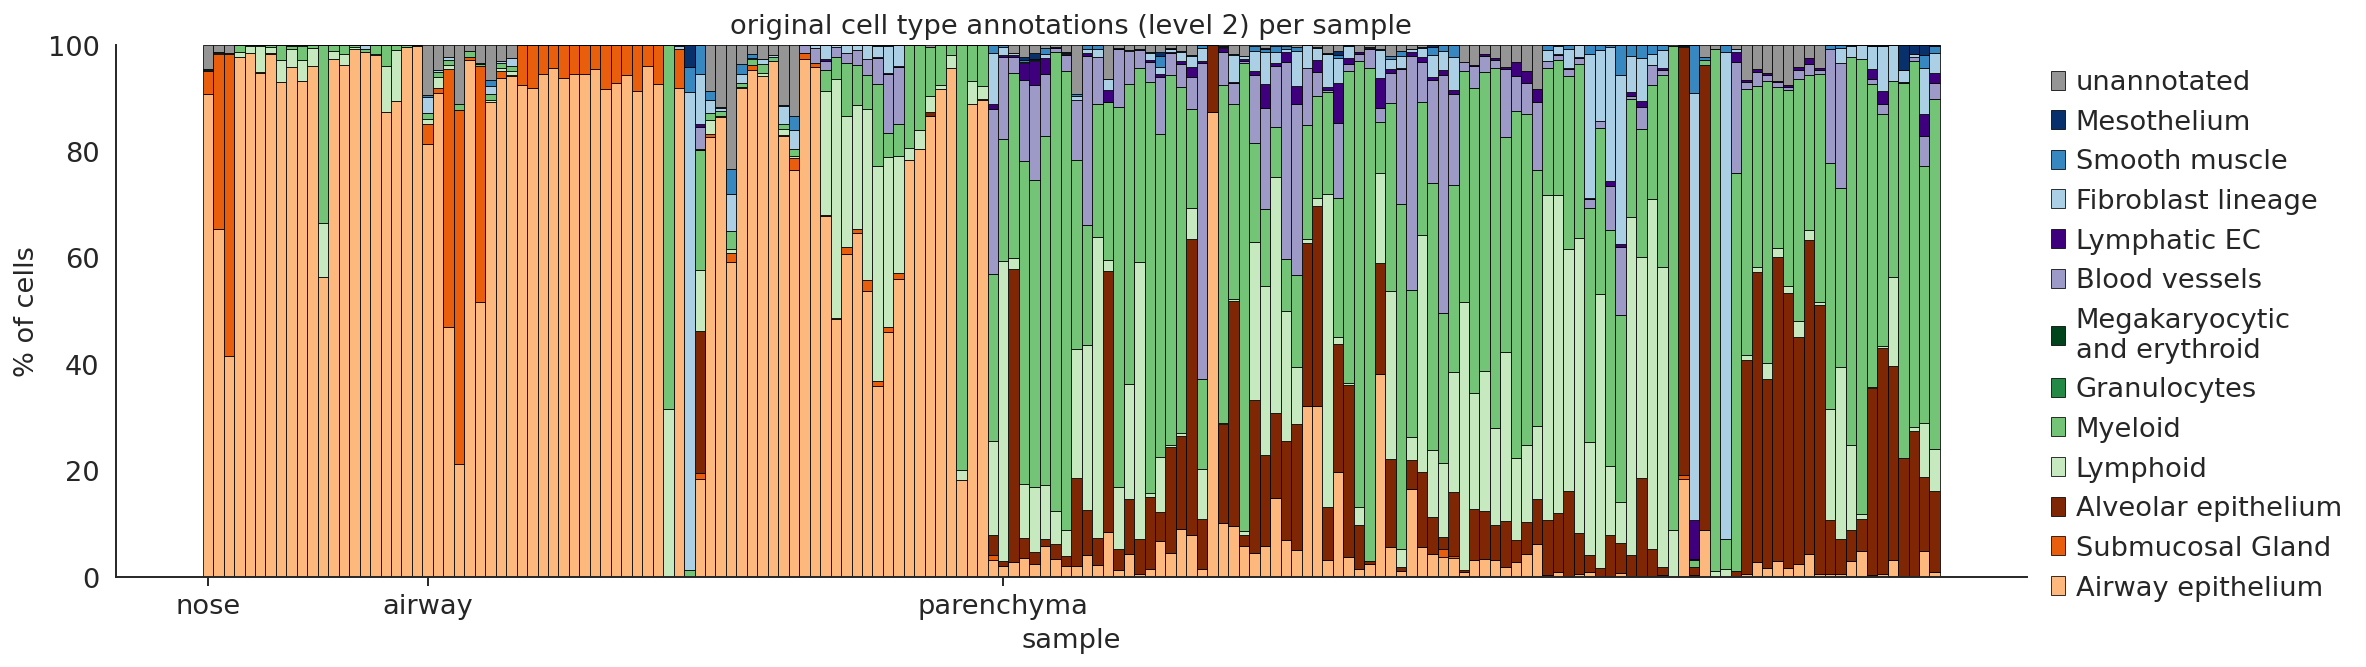

In [36]:
FIGURES[
    "2c_sample_compositions"
] = celltype_composition_plotting.plot_celltype_composition_per_sample(
    adata,
    ann_level_number,
    color_prop_df,
    return_fig=True,
    title="original cell type annotations (level 2) per sample",
    ann_level_name_prefix="original_ann_level_",
)

# Store figures

In [20]:
for figname, fig in FIGURES.items():
    print("Saving", figname)
    fig.savefig(
        os.path.join(dir_figures, f"{figname}.png"), bbox_inches="tight", dpi=140
    )

Saving 2a_subject_and_sample_stats
